In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#This folder holds the 30 .EVE files from Retrosheet
mypath = "C:\\Users\\Kane.Merrill\\Documents\\BTS_SQL\\2015eve\\"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
''' this function takes a list of file names, appends them to the hardcoded path, then reads the file line by line. Since the different 
lines in the file are of different 'lengths' we can't read directly into a pandas dataframe. This keeps track of the date, starttime,
hometeam and awayteam which are contained on separate rows before the 'play' rows of the respective game and appends that information
onto the beginning of each play record, and then creates a separate dataframe for each file of the play records which is either turned
into the main dataframe or appended to the main dataframe depending on if it is the first file read
'''

def create_table(lst,count = 0):
    for file in lst:
        path = "C:\\Users\\Kane.Merrill\\Documents\\BTS_SQL\\2015eve\\" + file

        data = [line.rstrip('\n') for line in open(path)]

        large_list = []
        date = None
        starttime = None
        hometeam = None
        awayteam = None

        for datum in data:
            if datum[5:9] == "date":
                date = datum[10:25]

            elif datum[5:14] == "starttime":
                starttime = datum[15:25]

            elif datum[5:12] == "visteam":
                awayteam = datum[13:17]

            elif datum[5:13] == "hometeam":
                hometeam = datum[14:17]  

            elif datum[0:4] == "play":
                lst = [date,starttime,hometeam,awayteam]

                for item in datum.split(","):
                    lst.append(item)

                large_list.append(lst)

        df = pd.DataFrame(large_list,columns=["date","starttime","hometeam","awayteam",\
                            "type_of_row","inning","home","id_code","pitch_count","pitches",\
                                                 "play_result"])
        if count == 0:
            full_table = df.copy(deep=True)
            count +=1
        else:
            full_table = full_table.append(df)
            count +=1
    
    return full_table

In [4]:
''' The first character in the play result column will be an S/D/T/H if the play was a hit (single, double, triple or home run
respectively)'''
def hits(x):
    if x[0] in ["S","D","T","H"] and "/" in x:
        return 1
    else:
        return 0

In [5]:
full_table = create_table(onlyfiles)

del full_table["type_of_row"]
full_table = full_table.reset_index(drop = True)

In [6]:
full_table["hit"] = full_table.play_result.map(hits)

In [7]:
#should equal 112 and 217,412
#it is crucial to always have a reference point when manipulating data, I have checked the hit totals from the data frame against the
#MLB stated totals and with the exception of Albert Pujols showing 148 hits in my data vs 147 for MLB every player I checked matched
#I would prefer to have it match perfectly but in my experience that is often unrealistic when comparing data from two different sources
#especially when it is impossible to track the respective data back to the source as it is here

print(full_table["hit"][full_table["id_code"] == "canhm001"].sum())

len(full_table)

112


217412

In [8]:
#this creates a team column that holds the team of the batter for that row
full_table["team"] = np.where(full_table["home"] == "1",full_table["hometeam"],\
                             full_table["awayteam"])

In [9]:
"""this runs through each team once, creates a dataframe with each row being a distinct combination of date and starttime of games
and then creates a game number column. This dataframe is then combined with all other game number dataframes and then joined to the
main dataframe so that each row also contains a column that tells the game number of the year for that batter"""
count = 0

for val in set(full_table["team"].values):    
    game_number = pd.DataFrame(full_table[["date","starttime","team"]]\
                               [full_table["team"] == val])

    game_number.drop_duplicates(inplace=True)

    game_number = game_number.reset_index(drop=True)

    game_number["game_number"] = game_number.index + 1

    game_number = game_number.set_index(keys=["date","starttime","team"])
    
    if count == 0:
        new_table = game_number.copy(deep=True)
        count +=1
    
    else:
        new_table = new_table.append(game_number)

In [10]:
#this should equal 30
len(set((full_table["team"].values)))

30

In [11]:
full_table = full_table.join(new_table, on = ["date","starttime","team"])
#at this point we now have a data frame that contains a row for each at bat in the 2015 MLB season along with some basic colums

In [15]:
full_table.head()

,date,starttime,hometeam,awayteam,inning,home,id_code,pitch_count,pitches,play_result,hit,team,game_number
0,2015/04/10,7:12PM,ANA,KCA,1,0,escoa003,22,FSBFBX,63/G,0,KCA,1
1,2015/04/10,7:12PM,ANA,KCA,1,0,mousm001,00,X,6/P,0,KCA,1
2,2015/04/10,7:12PM,ANA,KCA,1,0,cainl001,10,BX,D8/L+,1,KCA,1
3,2015/04/10,7:12PM,ANA,KCA,1,0,hosme001,22,CBFFB>X,S9/G.2-H,1,KCA,1
4,2015/04/10,7:12PM,ANA,KCA,1,0,morak001,22,FBBFX,S7/L+.1-2,1,KCA,1


<b> Basic Probability and Terminology</b>

In [50]:
#to use some of the basic topics from the class to explore our baseball data I am first going to create
#a table that has the number of at bats, the number of hits and thn will add in hits per at bat

basic_player_table = pd.DataFrame(full_table.groupby('id_code')["hit"].agg(['count',np.sum]))
basic_player_table["hits_per_at_bat"] = basic_player_table["sum"]/basic_player_table["count"]
basic_player_table.columns = ["at_bats","hits","hits_per_at_bat"]

#I dont want the id_code to be my index so I have to reset it
basic_player_table.reset_index(inplace=True)

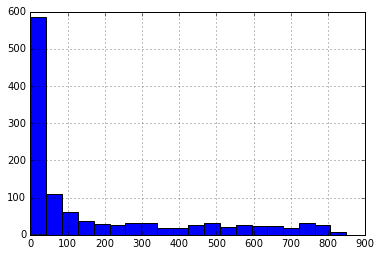

In [54]:
basic_player_table["at_bats"].hist(bins=20)

In [80]:
#there are a lot of players with fewer than 100 at bats that I believe should be elimiated from the analysis
#this dataframe shows the percentage of players with more at bats for each number of at bats

at_bats = pd.DataFrame(basic_player_table.groupby('at_bats')["id_code"].count())
at_bats.reset_index(inplace=True)
at_bats["cumsum"] = 1 -at_bats.id_code.cumsum()/at_bats.id_code.sum()

print(at_bats[at_bats["at_bats"]==151])
print(at_bats["id_code"][at_bats["at_bats"]>=151].sum())

     at_bats  id_code    cumsum
129      151        1  0.344304
409


In [83]:
#this leaves us with 409 players awho represent 34% of all players who had a major league appearance in 2015
#I will limit the data set to just these players
basic_player_table = pd.DataFrame(basic_player_table[basic_player_table["at_bats"]>=151])
basic_player_table.reset_index(inplace=True,drop=True)

In [84]:
basic_player_table.head()

,id_code,at_bats,hits,hits_per_at_bat
0,abrej003,778,178,0.228792
1,ackld001,323,55,0.170279
2,adamm002,212,42,0.198113
3,adrie001,159,22,0.138365
4,ahmen001,550,97,0.176364


In [90]:
# a large number of the basic statistical measures described in the first part of the class are avaiable with
#the 'describe' method
basic_player_table["hits"].describe()

count    409.000000
mean      96.760391
std       46.606733
min       21.000000
25%       54.000000
50%       95.000000
75%      136.000000
max      206.000000
Name: hits, dtype: float64

In [94]:
#co-efficienty of variation tells us the standard deviation in terms of the mean
basic_player_table["hits"].std() / basic_player_table["hits"].mean()

0.4816716039632421

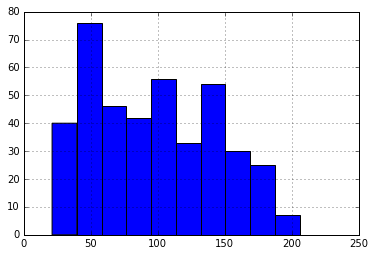

In [95]:
#the high inter-quartile range relative to the mean and the high co-efficent of variation tell us the 
#number of hits varies greatly amongst players, the histogram of this data backs this up
basic_player_table["hits"].hist()

In [96]:
#hits per at bat likely varies less and will provide more meaningful data for analysis since hits is naturally
#going to vary by the number of at bats by player which we saw earlier varies within this data set from 150
#to over 800
basic_player_table["hits_per_at_bat"].describe()

count    409.000000
mean       0.198586
std        0.028937
min        0.114130
25%        0.179551
50%        0.200793
75%        0.219807
max        0.275064
Name: hits_per_at_bat, dtype: float64

In [97]:
#this variation is significantly lower than the 48% result we saw for hits, since this data is essentially
#normalized by the number of at bats
basic_player_table["hits_per_at_bat"].std() / basic_player_table["hits_per_at_bat"].mean()

0.14571587592162477

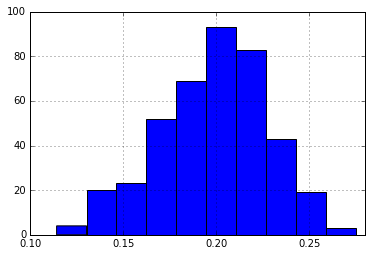

In [98]:
#this is not a perfect normal distribution due to some left skew but it is fairly close, we can see this in 
#the histogram below but it was also evident from above when we saw that the mean was lower than the median
basic_player_table["hits_per_at_bat"].hist()

<b> Binomial Distribution</b>

In [174]:
#for the time being we will assume that there are 4 at bats per game by player and use the binomial
#distribution to understand the expected number of hits per game by players with different hits per at bat
#we want the probability of 1 or more hits which is 1 - the pmf of 0 hits
from scipy.stats import binom

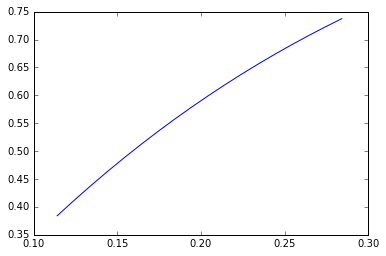

In [166]:
#It is useful to plot how the likelyhood of getting a hit changes as the hits per at bat increases, it is 
#slightly different from a linear relationshop


x = []
y = []

for i in np.arange(basic_player_table["hits_per_at_bat"].min(),
                   basic_player_table["hits_per_at_bat"].max()+.01,
                   .01):
    prob = 1 - binom.pmf(0,4,i)
    x.append(i)
    y.append(prob)

plt.plot(x,y)

In [173]:
1 - binom.pmf(0,4,.16)

0.50212864000000001

In [176]:
#at a hits per at bat of .16 there is a 50% chance of getting at least one hit in 4 at bats
len(basic_player_table[basic_player_table["hits_per_at_bat"]>=.16])

368

In [242]:
player_mask = pd.DataFrame(basic_player_table[basic_player_table["hits_per_at_bat"]>=.16])

In [243]:
player_mask.head()

,id_code,at_bats,hits,hits_per_at_bat
0,abrej003,778,178,0.228792
1,ackld001,323,55,0.170279
2,adamm002,212,42,0.198113
4,ahmen001,550,97,0.176364
5,almoa001,287,58,0.202091


In [186]:
#the problem is that 4 is not a realistic number of at bats per game, it will vary by player but for now
#lets just assume it is equal and get the distribution


In [246]:
masked_full_table = pd.merge(full_table,player_mask,how='right')

In [248]:
#should equal 368 if this has been done correclty
len(set(masked_full_table.id_code.values))

368

In [258]:
at_bats_per_game = pd.DataFrame(masked_full_table.groupby(['id_code','game_number'])["hit"].count())

In [259]:
data = pd.DataFrame(at_bats_per_game.hit.value_counts()/len(at_bats_per_game.hit))

In [260]:
at_bat_proportions = pd.DataFrame(at_bats_per_game.hit.value_counts(normalize=True,sort=False))

In [261]:
at_bat_proportions.head()

,hit
1,0.082071
2,0.025584
3,0.083542
4,0.330638
5,0.262363


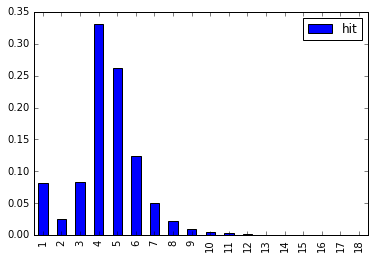

In [262]:
at_bat_proportions.plot(kind='bar')

In [263]:
#we will lump everything above 10 into 10 for the simplisities sake
at_bat_proportions.hit.ix[10] = at_bat_proportions.hit.ix[10:].sum()

In [264]:
at_bat_proportions.hit.ix[10]

0.0095819242268293872

In [265]:
at_bat_proportions = at_bat_proportions[:10]

In [266]:
at_bat_proportions.hit.ix[1]

0.082071264029799543

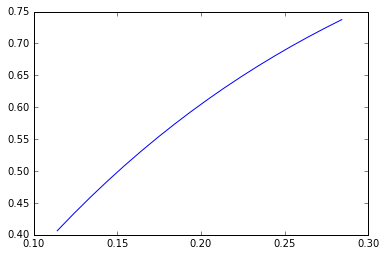

In [267]:
#now that we have the at bat proportions for all players, we can use it to get a prob a hit in any given 
#game using the various hits per at bat --THIS IS CLEARLY WRONG SINCE WE ARE INCLUDING PLAYERS WITH FEWER
#than 150 at bats

#It is useful to plot how the likelyhood of getting a hit changes as the hits per at bat increases, it is 
#slightly different from a linear relationshop


x = []
y = []

for i in np.arange(basic_player_table["hits_per_at_bat"].min(),
                   basic_player_table["hits_per_at_bat"].max()+.01,
                   .01):
    prob = 0
    for j in range(1,11):
        prob = prob + ((1 - binom.pmf(0,j,i)) * at_bat_proportions.ix[j])
    x.append(i)
    y.append(prob)

plt.plot(x,y)



In [278]:
#we are back to needing a .17 probability of a hit per at bat to have a better than .5 chance of getting a 
#hit in a game

prob = 0
for j in range(1,11):
    prob = prob + ((1 - binom.cdf(0,j,.151)) * at_bat_proportions.hit.ix[j])
prob

0.50070994628466547

The next question is whether or not players streak, or are there more anomolous games of many hits than 
would be expected. If so, we can start to examine those games for what might be different

In [283]:
good_player_table = pd.DataFrame(masked_full_table.groupby(['id_code','game_number'])["hit"].\
                                 agg(['count',np.sum]))
good_player_table.reset_index(inplace=True)

In [299]:
good_player_table.head()

,id_code,game_number,count,sum,at_bats,hits,hits_per_at_bat,likelihood
0,abrej003,1,4,0,778,178,0.228792,0.353742
1,abrej003,2,4,3,778,178,0.228792,0.036945
2,abrej003,3,4,0,778,178,0.228792,0.353742
3,abrej003,4,8,1,778,178,0.228792,0.296983
4,abrej003,5,4,0,778,178,0.228792,0.353742


In [285]:
good_player_table = pd.merge(good_player_table,player_mask)

In [298]:
good_player_table["likelihood"] = binom.pmf(good_player_table["sum"],\
                    good_player_table["count"],good_player_table["hits_per_at_bat"])

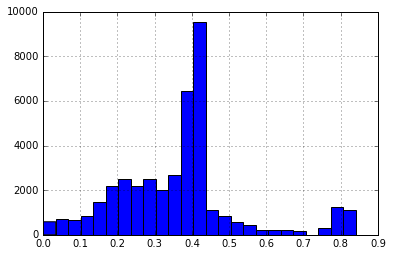

In [302]:
good_player_table.likelihood.hist(bins=25)

In [316]:
good_player_table_two[["hits_per_at_bat","at_bats"]].corr()

,hits_per_at_bat,at_bats
hits_per_at_bat,1.000000,0.278648
at_bats,0.278648,1.000000


In [311]:
good_player_table_two = pd.DataFrame(good_player_table[["id_code","hits","at_bats","hits_per_at_bat"]])

In [313]:
good_player_table_two.drop_duplicates(inplace=True)

In [318]:
good_player_table.head()

,id_code,game_number,count,sum,at_bats,hits,hits_per_at_bat,likelihood
0,abrej003,1,4,0,778,178,0.228792,0.353742
1,abrej003,2,4,3,778,178,0.228792,0.036945
2,abrej003,3,4,0,778,178,0.228792,0.353742
3,abrej003,4,8,1,778,178,0.228792,0.296983
4,abrej003,5,4,0,778,178,0.228792,0.353742


In [325]:
good_player_table["sum"].autocorr(lag=4)

0.034904627854103365

In [328]:
for i in set(good_player_table["id_code"]):
    if(good_player_table[good_player_table["id_code"]==i]["sum"].autocorr(lag=1) > .15):
        print(i,good_player_table[good_player_table["id_code"]==i]["sum"].autocorr(lag=1))

gillc002 0.195339805825
pillk001 0.19812979602
ozunm001 0.163487410456
trumm001 0.243959803293
longe001 0.223840227642
tomay001 0.164661168745
utlec001 0.159532540579
ruppc001 0.184561874221
aokin001 0.192242473639
santd001 0.198316396093
tuckp001 0.156806799699
gomey001 0.159603969562
owinc001 0.157652877722
byrdm001 0.326137426769
martk001 0.340682947344
thomt002 0.272830003854
odorr001 0.158488089713
parej002 0.225724020443
bradj001 0.213291766379
santd002 0.159744612766
buxtb001 0.314988896565
sprig001 0.289432789084
schoj001 0.307734969347
guyeb001 0.205208537302
kipnj001 0.310273429427
cespy001 0.181145398575
parrg001 0.189872509365
reveb001 0.165861960203
polag001 0.159420289855
piscs001 0.180534695104
fowld001 0.161236885699
bettm001 0.272876892693
phamt001 0.274432379072
navad001 0.20534016448


In [330]:
good_player_table_two[good_player_table_two["id_code"]=="kipnj001"]

,id_code,hits,at_bats,hits_per_at_bat
20566,kipnj001,172,730,0.235616


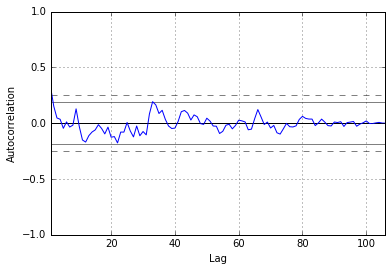

In [333]:
pd.tools.plotting.autocorrelation_plot(good_player_table[good_player_table["id_code"]=="byrdm001"]["sum"])

In [335]:
#it appears that streaks of number of hits really do not happen very often for this set of players, but lets
#check if it happens when looking at a purely binary measure of whether they got a hit in a game or not

good_player_table["binary_hit"] = good_player_table["sum"].map(lambda x: 0 if x == 0 else 1)

In [337]:
for i in set(good_player_table["id_code"]):
    if(good_player_table[good_player_table["id_code"]==i]["binary_hit"].autocorr(lag=1) > .15):
        print(i,good_player_table[good_player_table["id_code"]==i]["binary_hit"].autocorr(lag=1))

gillc002 0.214285714286
butlb003 0.213558535991
tomay001 0.152173913043
suzui001 0.211821079164
holtb002 0.181848241863
santd001 0.249530956848
middw001 0.178947368421
davir003 0.159679878049
byrdm001 0.216311624303
ynoar001 0.167590034767
ellsj001 0.155710330082
uribj002 0.295752825272
parej002 0.179914529915
pedrd001 0.304833753394
buxtb001 0.278207442037
schoj001 0.255862068966
joneg002 0.177989130435
guyeb001 0.215311004785
canor001 0.174856674857
darnt001 0.238461538462
ramow001 0.192307692308
uptob001 0.213454519628
polag001 0.173758200562
piscs001 0.326086956522
bettm001 0.201886792453
piera001 0.16875
herne001 0.253036349105
navad001 0.259677419355


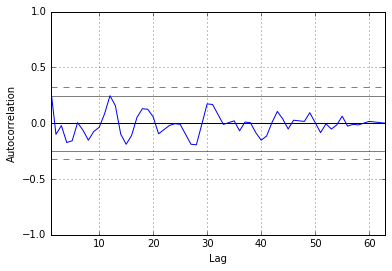

In [341]:
pd.tools.plotting.autocorrelation_plot(good_player_table[good_player_table["id_code"]=="piscs001"]\
                                       ["binary_hit"])